In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15961659004384832050
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3129973145
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12637636718549149591
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.4.0


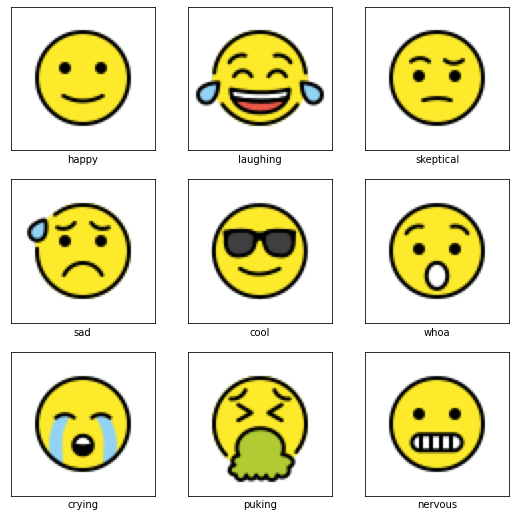

In [3]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [5]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row, col = np.random.randint(0, 72), np.random.randint(0, 72)
    image[row:row+72, col:col+72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row+8)/144, (col+8)/144

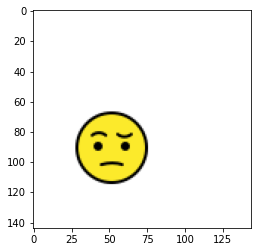

In [6]:
image, class_id, row, col = create_example()
plt.imshow(image)

In [7]:
def plot_bounding_box(image, true_coords, pred_coords=[], norm=False):
    if norm:
        image *= 255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row, col = true_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col+56, row+56), outline='green', width=2)
    
    if len(pred_coords)==2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col+56, row+56), outline='red', width=2)
        
    return image

Text(0.5, 1.0, 'skeptical')

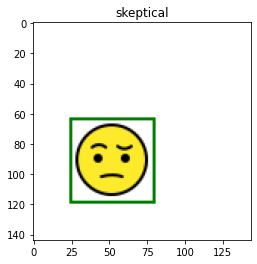

In [8]:
image = plot_bounding_box(image, (row, col))
plt.imshow(image)
plt.title(emojis[class_id]['name'])

In [9]:
def data_gen(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

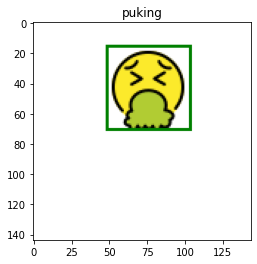

In [10]:
example, label = next(data_gen(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

In [11]:
input_ = Input(shape=(144, 144, 3), name='image')
x = input_

for i in range(5):
    n_filters = 2**(4+i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# x = Conv2D(128, 3, activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(2)(x)
# x = Flatten()(x)
# x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name = 'class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows*144, cols*144
            y1, y2 = rows, rows+56
            x1, x2 = cols, cols+56
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x1 - x2) * tf.math.abs(y1 - y2)
        
        true_x1, true_y1, true_x2, true_y2 = get_box(y_true)
        pred_x1, pred_y1, pred_x2, pred_y2 = get_box(y_pred)
        
        int_x1 = tf.maximum(true_x1, pred_x1)
        int_y1 = tf.maximum(true_y1, pred_y1)
        int_x2 = tf.minimum(true_x2, pred_x2)
        int_y2 = tf.minimum(true_y2, pred_y2)
        
        int_area = get_area(int_x1, int_y1, int_x2, int_y2)
        uni_area = get_area(true_x1, true_y1, true_x2, true_y2) + get_area(pred_x1, pred_y1, pred_x2, pred_y2) - int_area
        
        iou = tf.math.divide(int_area, uni_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

In [13]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics = {
        'class_out': 'accuracy',
        'box_out': IoU(name = 'iou')
    }
)

In [14]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    true_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]
    
    true = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']
    
    image = plot_bounding_box(image, true_coords, pred_coords, norm=True)
    color = 'green' if true==pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'True: {true}', color=color)
    plt.xticks([])
    plt.yticks([])

In [15]:
def test(model):
    test_datagen = data_gen(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        test_model(model, test_datagen)
        
    plt.show()

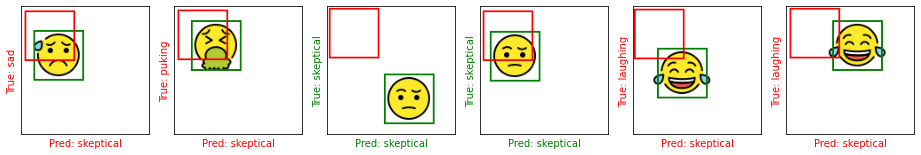

In [16]:
test(model)

In [17]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

Epoch 1/15
500/500 [==============================] - 32s 59ms/step - loss: 2.4081 - class_out_loss: 1.6628 - box_out_loss: 0.7453 - class_out_accuracy: 0.4372 - box_out_iou: 0.2175


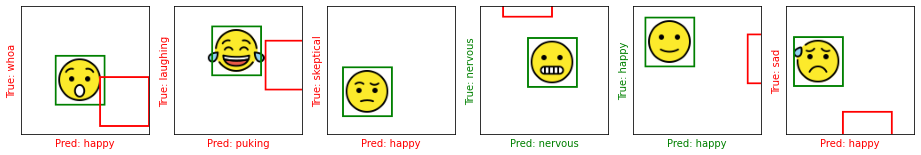

Epoch 2/15
500/500 [==============================] - 31s 63ms/step - loss: 0.0446 - class_out_loss: 0.0150 - box_out_loss: 0.0297 - class_out_accuracy: 0.9997 - box_out_iou: 0.3202


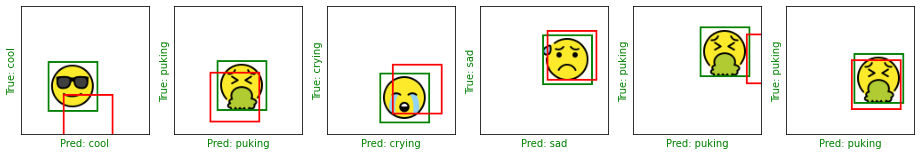

Epoch 3/15
500/500 [==============================] - 29s 57ms/step - loss: 0.0136 - class_out_loss: 0.0027 - box_out_loss: 0.0109 - class_out_accuracy: 1.0000 - box_out_iou: 0.4820


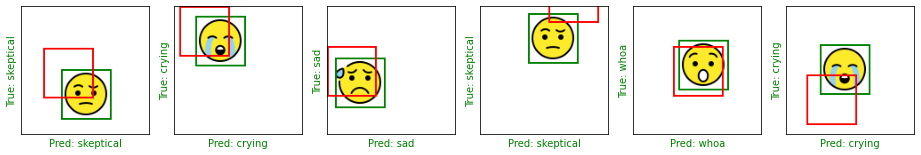

Epoch 4/15
500/500 [==============================] - 32s 64ms/step - loss: 0.0086 - class_out_loss: 0.0019 - box_out_loss: 0.0067 - class_out_accuracy: 1.0000 - box_out_iou: 0.5587


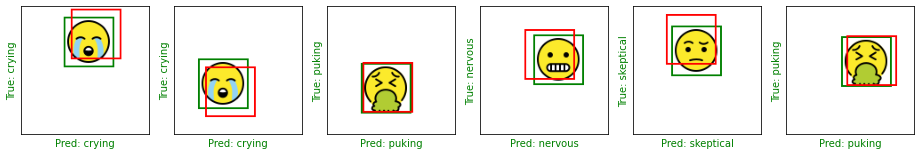

Epoch 5/15
500/500 [==============================] - 30s 60ms/step - loss: 0.0036 - class_out_loss: 8.1831e-04 - box_out_loss: 0.0028 - class_out_accuracy: 1.0000 - box_out_iou: 0.67693s -


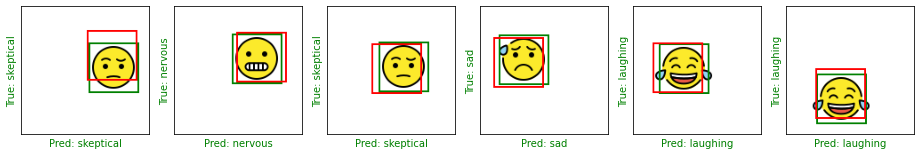

Epoch 6/15
500/500 [==============================] - 33s 67ms/step - loss: 0.0027 - class_out_loss: 6.0619e-04 - box_out_loss: 0.0021 - class_out_accuracy: 1.0000 - box_out_iou: 0.7121


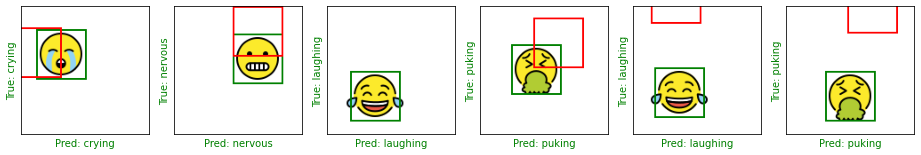

Epoch 7/15
146/500 [=======>......................] - ETA: 24s - loss: 0.0093 - class_out_loss: 0.0057 - box_out_loss: 0.0036 - class_out_accuracy: 0.9987 - box_out_iou: 0.647

KeyboardInterrupt: 

In [18]:
def lr_schedule(epoch, lr):
    if (epoch+1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

_ = model.fit(
    data_gen(),
    epochs=15,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)